# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import configparser
import datetime as dt
import numpy

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import *
from pyspark.sql.functions import *

import transform

In [2]:
import importlib
importlib.reload(transform)
from transform import drop_na_rows

### Step 1: Scope the Project and Gather Data


#### Scope
The project aims to build an ETL (Extract, Transform, Load) application using Apache Spark and Python to process and analyze immigration, demographics, and passenger flight data. The goal is to transform raw data into structured dimension and fact tables for further analysis.

#### Describe and Gather Data 
1 - Immigration Data: The immigration data is stored in SAS format and represents monthly records of immigrant arrivals in the United States. It contains various attributes such as arrival date, country of residence, state of arrival, visa type, and more.

2- Demographics Data: The demographics data represents information about US cities and includes attributes such as median age, male and female populations, number of veterans, foreign-born residents, average household size, etc.

3 - Passenger Flight Data: The passenger flight data provides information about international flight passengers, including flight details, airport codes, air carriers, and flight types.

4 - Global Temperatures Data: The global temperatures data contains temperature records for various cities and countries.

In [3]:
config = configparser.ConfigParser()
config.read('config.cfg')

os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']

In [4]:
spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

# I94 Immigration dataset

In [5]:
fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
Immigration_df = spark.read.format('com.github.saurfang.sas.spark').load(fname)

In [5]:
Immigration_df.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,...,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


In [ ]:
Immigration_df.count()

## Data Dictionary

| Feature   | Description                                                                   |
|-----------|-------------------------------------------------------------------------------|
| cicid     | Unique record ID                                                              |
| i94yr     | 4-digit year                                                                  |
| i94mon    | Numeric month                                                                 |
| i94cit    | 3-digit code for immigrant country of birth                                   |
| i94res    | 3-digit code for immigrant country of residence                               |
| i94port   | Port of admission                                                             |
| arrdate   | Arrival Date in the USA                                                       |
| i94mode   | Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)         |
| i94addr   | USA State of arrival                                                          |
| depdate   | Departure Date from the USA                                                   |
| i94bir    | Age of Respondent in Years                                                    |
| i94visa   | Visa codes collapsed into three categories                                    |
| count     | Field used for summary statistics                                             |
| dtadfile  | Character Date Field - Date added to I-94 Files                               |
| visapost  | Department of State where the Visa was issued                                 |
| occup     | Occupation that will be performed in U.S                                      |
| entdepa   | Arrival Flag - admitted or paroled into the U.S.                              |
| entdepd   | Departure Flag - Departed, lost I-94, or is deceased                          |
| entdepu   | Update Flag - Either apprehended, overstayed, adjusted to perm residence      |
| matflag   | Match flag - Match of arrival and departure records                           |
| biryear   | 4-digit year of birth                                                         |
| dtaddto   | Character Date Field - Date to which admitted to U.S. (allowed to stay until) |
| gender    | Non-immigrant sex                                                             |
| insnum    | INS number                                                                    |
| airline   | Airline used to arrive in the U.S.                                            |
| admnum    | Admission Number                                                              |
| fltno     | Flight number of Airline used to arrive in the U.S.                           |
| visatype  | Class of admission legally admitting the non-immigrant to temporarily stay    |
|           | in the U.S.                                                                   |                                                       

# World Temperature Data: Data Description
The World Temperature dataset comes from Kaggle and represents global land temperatures by city.



In [6]:
file_name = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature_df = spark.read.csv(file_name, header=True, inferSchema=True)

In [7]:
# display the first five records
temperature_df.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [ ]:
# check the total number of records
temperature_df.count()

## Data Dictionary

| Feature                      | Description                                                |
|------------------------------|------------------------------------------------------------|
| dt                           | Date                                                       |
| AverageTemperature           | Global average land temperature in Celsius               |
| AverageTemperatureUncertainty | 95% confidence interval around the average               |
| City                         | Name of City                                               |
| Country                      | Name of Country                                            |
| Latitude                     | City Latitude                                              |
| Longitude                    | City Longitude                                             |


## U.S. City Demographic Data: Data Description

In [7]:
file_name = "us-cities-demographics.csv"
demographics_df = spark.read.csv(file_name, inferSchema=True, header=True, sep=';')

In [9]:
# display the first five records
demographics_df.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


### Data dictionary


| Feature              | Description                                              |
|----------------------|----------------------------------------------------------|
| City                 | City Name                                                |
| State                | US State where city is located                           |
| Median Age           | Median age of the population                             |
| Male Population      | Count of male population                                 |
| Female Population    | Count of female population                               |
| Total Population     | Count of total population                                |
| Number of Veterans   | Count of total Veterans                                  |
| Foreign born         | Count of residents of the city that were not born in the city |
| Average Household Size | Average city household size                             |
| State Code           | Code of the US state                                     |
| Race                 | Respondent race                                          |
| Count                | Count of city's individuals per race                     |


## U.S. Passenger flight information


In [8]:
flights_df = spark.read.csv('International_Report_Passengers.csv', inferSchema=True, header=True)

In [6]:
flights_df.limit(5).toPandas()

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,05/01/2014,2014,5,14492,RDU,36,11032,CUN,148,19534,AM,0,Passengers,0,315,315
1,06/01/2007,2007,6,13204,MCO,33,16085,YHZ,951,20364,C6,0,Passengers,0,683,683
2,12/01/2005,2005,12,11433,DTW,43,10411,AUA,277,20344,RD,1,Passengers,0,1010,1010
3,04/01/2003,2003,4,13487,MSP,63,16304,ZIH,148,20204,MG,1,Passengers,0,508,508
4,12/01/2005,2005,12,12016,GUM,5,11138,CRK,766,20312,TZ,1,Passengers,0,76,76


### Data dictionary


| Feature              | Description                                              |
|----------------------|----------------------------------------------------------|
| data_dte                 | Date of flight                                                |
| Year                     | Year of flight                          |
| Month                    | Month of flight                             |
| usg_apt_id              | US Gateway Airport ID - assigned by US DOT to identify an airport                                 |
| usg_apt    | US Gateway Airport Code                               |
| usg_wac     | US Gateway World Area Code                                |
| fg_apt_id   | Foreign Gateway Airport ID                                  |
| fg_apt         | Foreign Gateway Airport Code |
| fg_wac | Foreign Gateway World Area Code                              |
| airlineid             | Airline ID                                      |
| carrier                | IATA-assigned air carrier code                                         |
| carriergroup                | Carrier Group Code - 1 denotes US domestic air carriers,                     |
| type             | The type of the metrics                                     |
|Scheduled            |    Metric flown by scheduled service operations          |
| Charter                | Metric flown by charter operations                                         |
| Total                | Total Total Metric flown by scheduled service                    |



### Step 2: Explore and Assess the Data
#### Explore the Data 
I will now explore each dataset using the transform function that I have created within the transform script of the ETL application.


## 194 immigration data cleaning


In [9]:
#Show the percentages of missing values per row using show_percentage_missing function
transform.show_percentage_missing(Immigration_df)

        cols   values  % missing values
0      cicid        0          0.000000
1      i94yr        0          0.000000
2     i94mon        0          0.000000
3     i94cit        0          0.000000
4     i94res        0          0.000000
5    i94port        0          0.000000
6    arrdate        0          0.000000
7    i94mode      239          0.007719
8    i94addr   152592          4.928184
9    depdate   142457          4.600859
10    i94bir      802          0.025902
11   i94visa        0          0.000000
12     count        0          0.000000
13  dtadfile        1          0.000032
14  visapost  1881250         60.757746
15     occup  3088187         99.737559
16   entdepa      238          0.007687
17   entdepd   138429          4.470769
18   entdepu  3095921         99.987340
19   matflag   138429          4.470769
20   biryear      802          0.025902
21   dtaddto      477          0.015405
22    gender   414269         13.379429
23    insnum  2982605         96.327632


In [ ]:
Immigration_df = transform.drop_na_rows(Immigration_df)

## World Temperature Data cleaning 

In [12]:
#Change format of dt column in order to correct any values as required
temperature_df = temperature_df.withColumn("dt", unix_timestamp("dt").cast("float"))

#Show the percentages of missing values per row using show_percentage_missing function
transform.show_percentage_missing(temperature_df)

                            cols  values  % missing values
0                             dt       0          0.000000
1             AverageTemperature  364130          4.234458
2  AverageTemperatureUncertainty  364130          4.234458
3                           City       0          0.000000
4                        Country       0          0.000000
5                       Latitude       0          0.000000
6                      Longitude       0          0.000000


In [13]:
temperature_df.count()

8599212

## US City Demographic Data Cleansing 

In [14]:
transform.show_percentage_missing(demographics_df)


                      cols  values  % missing values
0                     City       0          0.000000
1                    State       0          0.000000
2               Median Age       0          0.000000
3          Male Population       3          0.103770
4        Female Population       3          0.103770
5         Total Population       0          0.000000
6       Number of Veterans      13          0.449671
7             Foreign-born      13          0.449671
8   Average Household Size      16          0.553442
9               State Code       0          0.000000
10                    Race       0          0.000000
11                   Count       0          0.000000


In [ ]:
demographics_df = transform.drop_na_rows(demographics_df)

## U.S. Passenger flight information Cleansing 

In [15]:
transform.show_percentage_missing(flights_df)

            cols  values  % missing values
0       data_dte       0               0.0
1           Year       0               0.0
2          Month       0               0.0
3     usg_apt_id       0               0.0
4        usg_apt       0               0.0
5        usg_wac       0               0.0
6      fg_apt_id       0               0.0
7         fg_apt       0               0.0
8         fg_wac       0               0.0
9      airlineid       0               0.0
10       carrier       0               0.0
11  carriergroup       0               0.0
12          type       0               0.0
13     Scheduled       0               0.0
14       Charter       0               0.0
15         Total       0               0.0


In [ ]:
flights_df = transform.drop_na_rows(flights_df)

### For Cleaning steps plese see steps outlined in transform.py ##

## Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

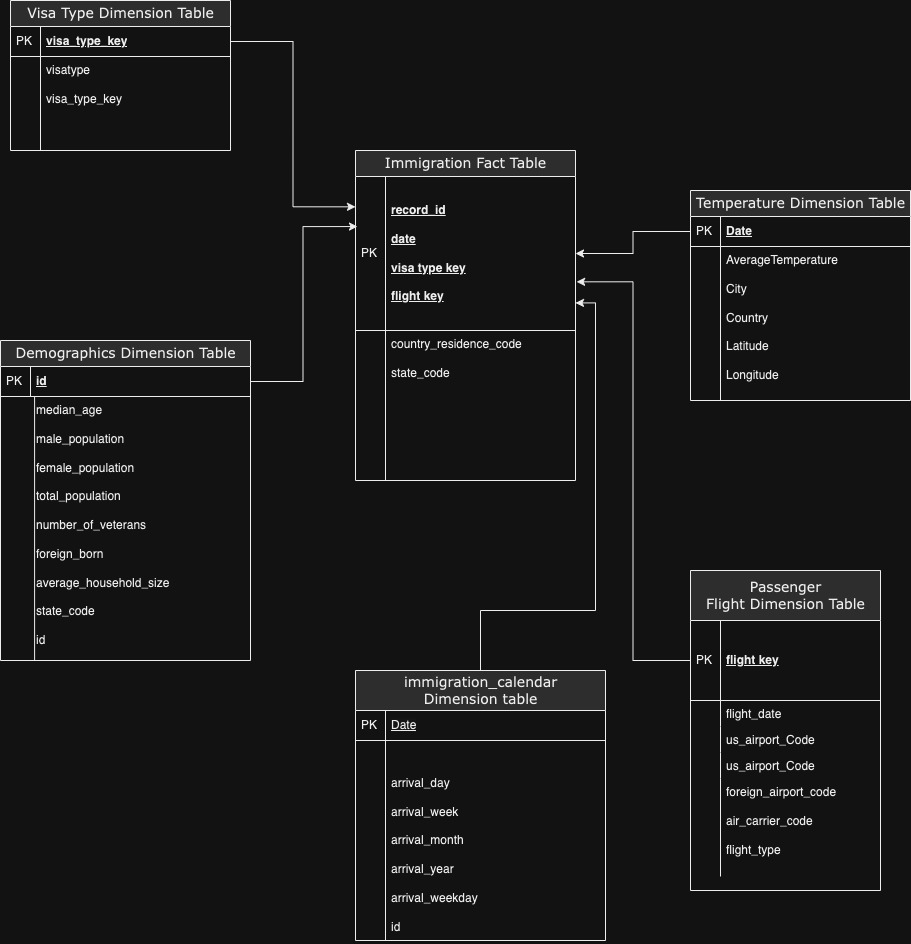

The data model for this project consists of dimension and fact tables designed to efficiently store and organize the immigration and passenger flight data. The data model is justified based on the principles of data normalization, the need for efficient querying, and the goal of enabling insightful analysis and reporting. Below is a detailed description and justification of the data model:

### Step 4: Run Pipelines to Model the Data 
### For Data model steps plese see steps outlined in etl.py ##

#### 4.2 Data Quality Checks
All Data Quality checks are integrated with the script. Once etl.py is ran tables will be dq checked using the following function: <br> # Perform quality checks here
def quality_checks(df, table_name):<br>
    """Count checks on fact and dimension table to ensure completeness of data.

    :param df: spark dataframe to check counts on
    :param table_name: corresponding name of table
    """
    total_count = df.count()

    if total_count == 0:
        print(f"Data quality check failed for {table_name} with zero records!")
    else:
        print(f"Data quality check passed for {table_name} with {total_count:,} records.")
    return 0

### 4.3 Data dictionary 


#### Dimension Tables:

1. Flight Dim:
    - **id**: Integer - Unique identifier for the flight record.
    - **flight_date**: Date - Date of the flight.
    - **us_airport_Code**: String - Code of the U.S. airport.
    - **foreign_airport_code**: String - Code of the foreign airport.
    - **air_carrier_code**: String - Code of the air carrier.
    - **flight_type**: String - Type of the flight.

2. Demographics Dim:
    - **id**: Integer - Unique identifier for the demographic record.
    - **median_age**: Double - Median age of the city population.
    - **male_population**: Integer - Total male population in the city.
    - **female_population**: Integer - Total female population in the city.
    - **total_population**: Integer - Total population in the city.
    - **number_of_veterans**: Integer - Total number of veterans in the city.
    - **foreign_born**: Integer - Total number of foreign-born residents in the city.
    - **average_household_size**: Double - Average household size in the city.
    - **state_code**: String - Code of the state where the city is located.

3. Visa Type Dim:
    - **visa_type_key**: Integer - Unique identifier for the visa type.
    - **visatype**: String - Type of visa.

4. Temperature Dim:
    - **date**: Date - Date for the temperature record.
    - **average_temperature**: Double - Average temperature on the given date.

5. Time Dim:
    - **id**: Integer - Unique identifier for the time record.
    - **arrdate**: Date - Arrival date in SAS format.
    - **arrival_day**: Integer - Day of the month of arrival.
    - **arrival_week**: Integer - Week of the year of arrival.
    - **arrival_month**: Integer - Month of arrival.
    - **arrival_year**: Integer - Year of arrival.
    - **arrival_weekday**: Integer - Day of the week of arrival.


#### Fact Table:

1. Immigration Fact:
    - **record_id**: Integer - Unique identifier for the immigration record.
    - **country_residence_code**: Integer - Code of the country of residence.
    - **state_code**: String - Code of the state in the U.S.
    - **visa_type_key**: Integer - Foreign key referencing the visa type from the visa type dimension.
    - **flight_id**: Integer - Foreign key referencing the flight record from the flight dimension.
    - **demographics_id**: Integer - Foreign key referencing the demographic record from the demographics dimension.
    - **temperature_id**: Integer - Foreign key referencing the temperature record from the temperature dimension.
    - **time_id**: Integer - Foreign key referencing the time record from the time dimension.

#### Step 5: Complete Project Write Up

Frequency of Data Update:

The frequency of data update should be determined by the source of the data and the business requirements. In general, for an immigration data warehouse, the data could be updated on a monthly basis, as immigration records are often reported monthly. However, this may vary based on the source and availability of data. It's essential to strike a balance between the frequency of data updates and the resources required for data processing.

Scenarios:

1. The Data Was Increased by 100x:

If the data was increased by 100x, the current system may face performance issues due to the increased data volume. In such a scenario, the following strategies could be employed:

Utilize a distributed storage system: Switch to distributed storage systems like Hadoop Distributed File System (HDFS) or Amazon S3 to handle large volumes of data efficiently.
Scale the compute resources: Deploy the Spark cluster on a cloud-based platform like AWS EMR, and use auto-scaling to dynamically adjust the compute resources based on workload.
Optimize data processing: Implement performance optimizations like partitioning, bucketing, and caching to improve query performance.
2. The Data Populates a Dashboard Updated Daily by 7 am:

To meet the requirement of updating the dashboard daily by 7 am, the following steps can be taken:

Schedule ETL pipeline: Set up an automated ETL pipeline using Apache Airflow or a similar tool to extract, transform, and load the data into the data warehouse.
Incremental data loading: Instead of processing the entire dataset daily, use incremental data loading techniques to process only the new or changed data since the last update, reducing processing time.
Optimize ETL process: Optimize data processing tasks to minimize execution time, ensuring that the pipeline completes before the specified deadline.
3. The Database Needs to Be Accessed by 100+ People:

To support a large number of concurrent users accessing the database, consider the following:

Use a distributed database: Utilize a distributed database system like Amazon Redshift which can handle concurrent queries from multiple users efficiently.
Data replication: Set up data replication or clustering to ensure high availability and load balancing for improved performance.
Implement access controls: Apply role-based access controls to manage user permissions and restrict access to sensitive data.
By considering the above scenarios and employing appropriate technologies, the data warehouse can be optimized to handle increased data volume, meet daily dashboard update requirements, and support a large number of users effectively.